In [65]:
import os
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, MaxPooling2D, Dropout, Conv2D, Flatten, Dense
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

### Dataset Preparation and Preprocessing

This code loads image data from the 'final_dataset' folder which contains over 20,000 images of handwritten Gujarati numerals (૦-૯), where each subfolder represents a different class (label). The images are resized to 28x28 pixels, converted to grayscale, and their colors are inverted. The dataset is then split into training and testing sets (90-10 ratio), with labels encoded as one-hot vectors. The images are normalized to a range of [0, 1] and reshaped to include a channel dimension, ensuring compatibility with neural network input requirements. Finally, the training and testing datasets are prepared for model training.

In [69]:
# Load training images from the 'final_dataset' folder
base_folder_path = r'final_dataset'

images = []
labels = []

for folder_name in os.listdir(base_folder_path):
    folder_path = os.path.join(base_folder_path, folder_name)
    if os.path.isdir(folder_path):
        # Use the entire folder name as the label
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.png', '.jpg')):
                img_path = os.path.join(folder_path, filename)
                img = Image.open(img_path).convert('L')  # Convert to grayscale
                img = img.resize((28, 28))  # Resize image to 28x28
                img = Image.fromarray(255 - np.array(img))  # Invert image color
                img_array = np.array(img)
                images.append(img_array)
                labels.append(int(folder_name))  # Use the folder name as label

# Convert images to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Normalize image pixel values to the range [0, 1]
images = images / 255.0

# Shuffle and split the dataset into training and testing datasets (90-10 ratio respectively)
train_dataset, test_dataset, train_labels, test_labels = train_test_split(images, labels, test_size=0.1, random_state=42)

# Add channel dimension to ensure the correct input shape for grayscale images
train_dataset = np.expand_dims(train_dataset, axis=-1)
test_dataset = np.expand_dims(test_dataset, axis=-1)

# One-hot encoding the labels
train_labels = to_categorical(train_labels, num_classes=10)
test_labels = to_categorical(test_labels, num_classes=10)

### Model Definition and Training

This code defines a Convolutional Neural Network (CNN) model with two convolutional layers, max-pooling layers, dropout layers for regularization, and dense layers for classification. The model uses the 'categorical_crossentropy' loss function, the Adam optimizer with a small learning rate, and tracks accuracy, precision, recall, and AUC as additional metrics. An early stopping callback is included to prevent overfitting by monitoring the validation loss. The model is then trained using the training dataset with a batch size of 10 for 12 epochs, with a validation split of 10% and early stopping based on the validation loss.

In [77]:
# Define the model
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Define custom metric names to use for plotting
precision_metric = Precision(name='precision')
recall_metric = Recall(name='recall')
auc_metric = AUC(name='auc')

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy', precision_metric, recall_metric, auc_metric])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_dataset,
    train_labels,
    batch_size=10,
    validation_split=0.1,
    epochs=12,
    callbacks=[early_stopping]
)

Epoch 1/12
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.5575 - auc: 0.8751 - loss: 1.3981 - precision: 0.8095 - recall: 0.3127 - val_accuracy: 0.8941 - val_auc: 0.9881 - val_loss: 0.4179 - val_precision: 0.9420 - val_recall: 0.8289
Epoch 2/12
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8672 - auc: 0.9868 - loss: 0.4421 - precision: 0.9179 - recall: 0.8154 - val_accuracy: 0.9370 - val_auc: 0.9959 - val_loss: 0.2247 - val_precision: 0.9581 - val_recall: 0.9196
Epoch 3/12
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9163 - auc: 0.9938 - loss: 0.2837 - precision: 0.9413 - recall: 0.8908 - val_accuracy: 0.9511 - val_auc: 0.9971 - val_loss: 0.1693 - val_precision: 0.9669 - val_recall: 0.9359
Epoch 4/12
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9407 - auc: 0.9967 - loss: 0.1964 - precision: 0.9578 - recall: 0.9242 - val_accuracy: 0.9587 - val_auc: 0.9982 - val_loss: 0.1379 - val_precision: 0.9699 - val_recall: 0.9468
Epoch 5/12
1657/1657 ━━

### Visualizations

This code visualizes the training history of the model by plotting various metrics (accuracy, loss, precision, recall, and AUC) for both training and validation datasets:

- Accuracy: Displays the training and validation accuracy over epochs.
- Loss: Displays the training and validation loss over epochs.
- Precision: Displays the training and validation precision over epochs.
- Recall: Displays the training and validation recall over epochs.
- AUC: Displays the training and validation AUC (Area Under the Curve) over epochs.

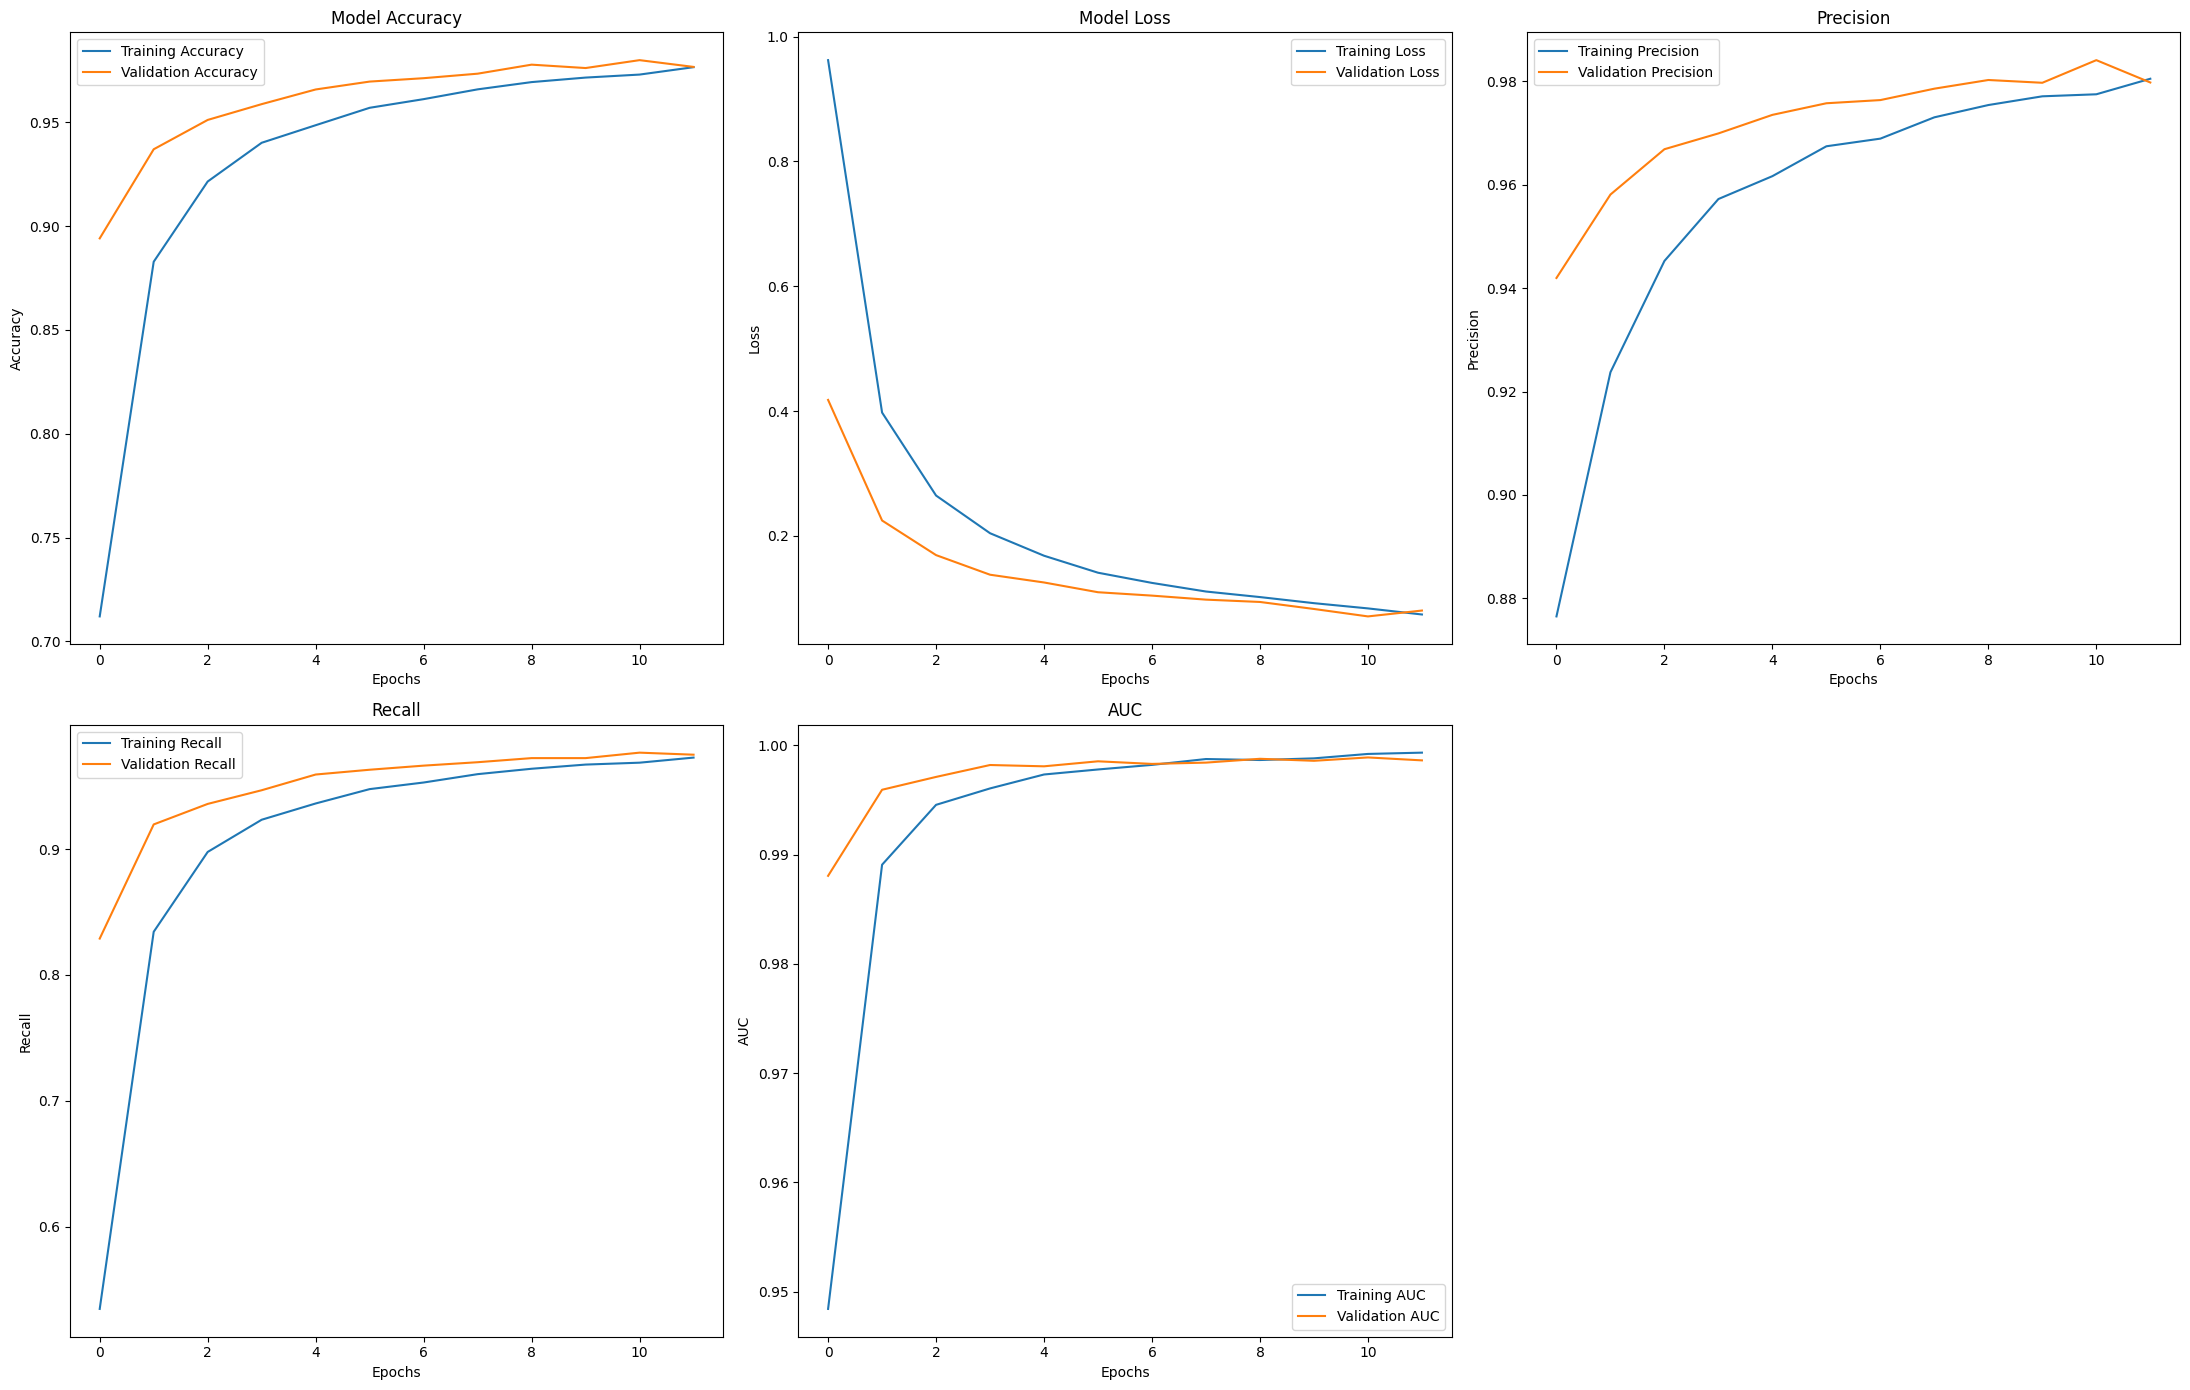

In [109]:
# Plot training history for accuracy, loss, precision, recall, and AUC
plt.figure(figsize=(22, 14))

# Plot training & validation accuracy values
plt.subplot(2, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(2, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation precision values
plt.subplot(2, 3, 3)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot training & validation recall values
plt.subplot(2, 3, 4)
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# Plot training & validation AUC values
plt.subplot(2, 3, 5)
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

# Adjust the spacing between the subplots
plt.subplots_adjust(hspace=0.5, wspace=0.5)

plt.tight_layout()
plt.show()

### Test dataset metrics

In [114]:
# Calculate metrics on the test_dataset
test_dataset = test_dataset.reshape(-1, 28, 28, 1)
results = model.evaluate(test_dataset, test_labels)
test_loss, test_acc, test_precision, test_recall, test_auc = results

print("Test dataset metrics:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9827 - auc: 0.9987 - loss: 0.0684 - precision: 0.9857 - recall: 0.9800
Test dataset metrics:
Test Loss: 0.0540
Test Accuracy: 0.9848
Test Precision: 0.9872
Test Recall: 0.9829
Test AUC: 0.9993


### Observations from Model Training and Evaluation

#### Training Metrics (Epoch 1 to Epoch 12)
- Training Accuracy: Increased significantly over time, showing continuous improvement.
- Training Loss: Decreased steadily, indicating the model was learning and reducing errors.
- Precision: Showed substantial improvement, reflecting better identification of positive instances.
- Recall: Improved consistently, highlighting the model's increasing ability to capture true positives.

#### Validation Metrics (Epoch 1 to Epoch 12)
- Validation Accuracy: Showed steady growth, confirming the model's ability to generalize well.
- Validation Precision: Increased throughout training, indicating better precision in classifying positive cases.
- Validation Recall: Improved progressively, demonstrating the model's enhanced capacity to identify true positives.
- Validation Loss: Decreased over time, suggesting fewer errors in predictions during validation.
- Validation AUC: Remained consistently high, indicating excellent model performance in distinguishing between classes.

#### Test Metrics
- Test Accuracy: Remained high, demonstrating strong performance on unseen data.
- Test Loss: Was low, indicating minimal error on the test set.
- Test Precision: Remained strong, showing the model's ability to correctly identify positive samples.
- Test Recall: Was consistently high, reflecting the model's effectiveness in detecting positive instances.
- Test AUC: Was near perfect, suggesting outstanding classification performance with excellent ability to discriminate between classes.

#### Overall:
- The model showed excellent performance, with continuous improvement across both training and test phases.
- Precision and recall were both strong, indicating a balanced model with effective positive class detection.
- The high AUC score highlights excellent calibration and discrimination.
- Overall, the model showed robustness, with good generalization to new data and no signs of overfitting.

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


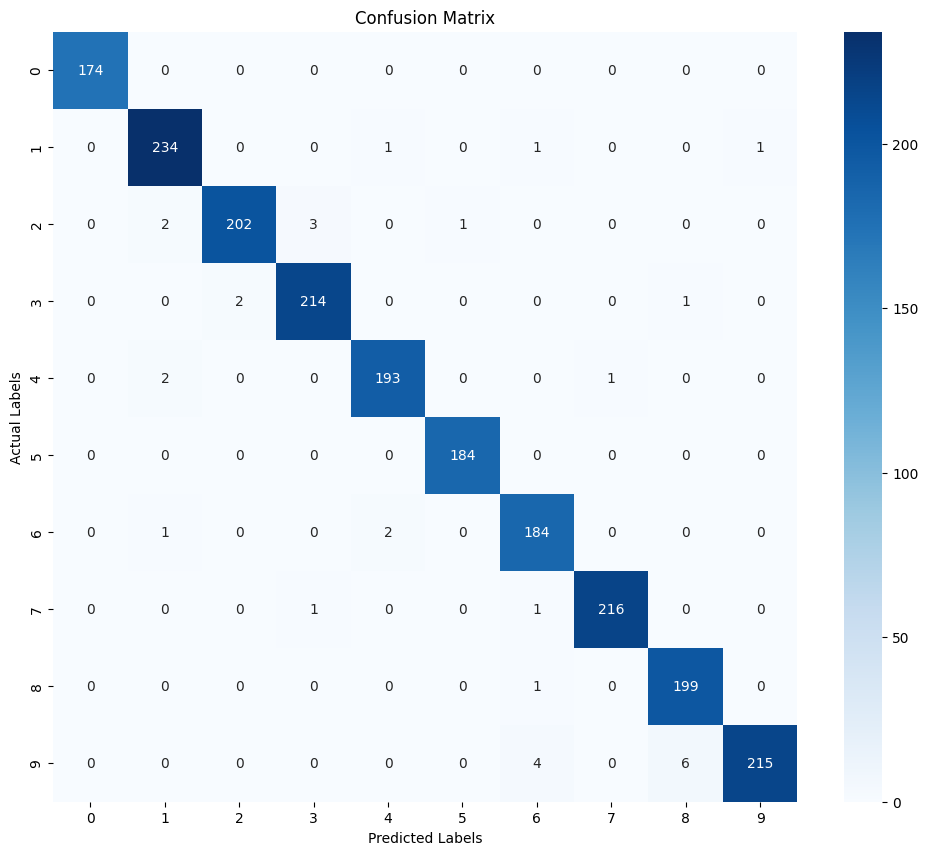

In [84]:
# Confusion matrix
# Predictions of the trained model on test_dataset
test_pred_prob = model.predict(test_dataset)  # Predict the test data
test_pred = np.argmax(test_pred_prob, axis=1)  # Convert probabilities to class labels
test_actual = np.argmax(test_labels, axis=1)  # Actual labels from one-hot encoded test_labels

# Compute the confusion matrix
cm = confusion_matrix(test_actual, test_pred)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

### Output Samples

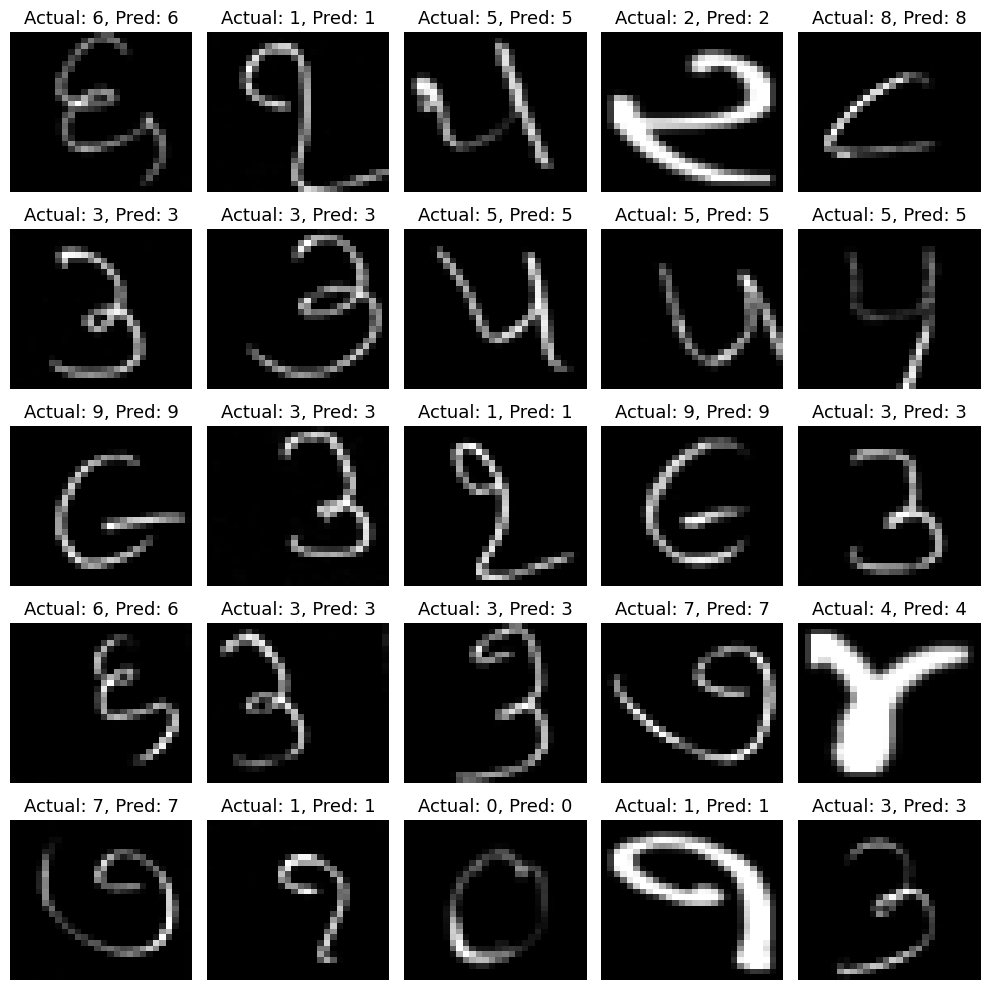

In [112]:
# Display 25 random images from the test dataset
random_indices = np.random.choice(len(test_dataset), 25, replace=False)

plt.figure(figsize=(10, 10))

for i, idx in enumerate(random_indices):
    plt.subplot(5, 5, i+1)    
    plt.imshow(test_dataset[idx].reshape(28, 28), cmap='gray', aspect='auto')
    plt.axis('off')
    actual_label = test_actual[idx]
    predicted_label = test_pred[idx]
    plt.title(f"Actual: {actual_label}, Pred: {predicted_label}", fontsize=13)

plt.tight_layout()
plt.show()

### Save the Trained Model

In [108]:
# Save the trained model into a file to be used for PyQT application
model.save('gujarati_numeral_recognition_model.keras')